In [1]:
# const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
using Revise
using ParallelStencil
# using ParallelStencil.FiniteDifferences3D
using GeoPhyInv
# import GeoPhyInv.Data
# import GeoPhyInv.FiniteDifferences2D
using ProgressMeter
using Distributed
using DistributedArrays
using CUDA
using NamedArrays
using OrderedCollections


using Plots, Printf, Statistics

# just to get revise working
GeoPhyInv.@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
plotly()
gr()


┌ Info: Precompiling GeoPhyInv [e0ed03db-c84c-5109-9210-aed666ad9ba8]
└ @ Base loading.jl:1317
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/backends.jl:435


Plots.GRBackend()

In [2]:
# medium=Medium(:marmousi2)


# mgrid_new=[range(-1000, stop=5000, length=255), range(-1000,20000,length=1000)];
# mediumup=update(medium,mgrid_new)

# mediumup=GeoPhyInv.padarray(medium, 400)
# heatmap(mediumup,:vs)


In [3]:
mgrid=fill(range(-1000, stop=1000, length=215), 3);
nz,ny,nx=length.(mgrid);
dz,dy,dx=step.(mgrid);
medium=Medium(mgrid,[:vp,:rho,:vs])
vpb = [3000., 3500.] # bounds for vp
vsb = [1900, 2000] # bounds for vs
rhob = [1., 2.] # density bounds
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);
fill!(medium);
# GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=5); # add some random noise
# medium

medium.bounds[:vs]

2-element Vector{Float64}:
 1900.0
 2000.0

> Medium
> number of samples:	[176, 851]
> sampling intervals:	[20.0, 20.0]
> vp:	min	1027.9998779296875	max	4699.999809265137
> vs:	min	0.0	max	2802.000045776367
> rho:	min	1.0099992752075195	max	2.626999855041504
> Bounds:
8-element Named Vector{Vector{Float64}}
vcat  │ 
──────┼─────────────────────────
:vp   │       [760.788, 4967.21]
:rho  │      [0.802716, 2.83428]
:vs   │           [0.0, 2918.24]
:K    │    [4.6461e5, 3.77481e7]
:KI   │ [2.64914e-8, 2.15234e-6]
:rhoI │      [0.352823, 1.24577]
:mu   │          [0.0, 2.4137e7]
:muI  │        [4.14301e-8, Inf]



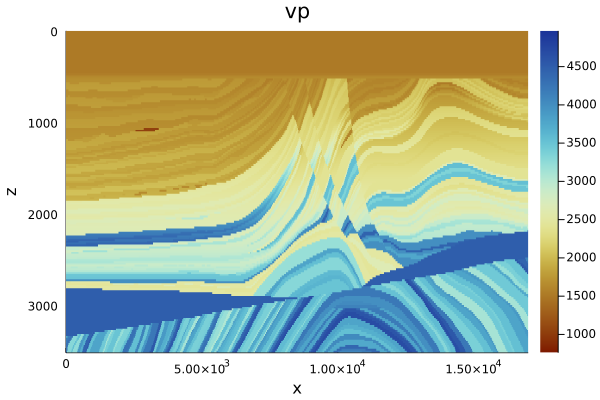

In [7]:
medium=Medium(:marmousi2,20)
println(medium)
mgrid=medium.mgrid
nz,nx=length.(mgrid);
dz,dx=step.(mgrid);
# fill!(medium)
heatmap(medium)

In [4]:

ageom=AGeom(medium.mgrid, SSrcs(1), [Srcs(1)], [Recs(10)])
# fill!.(ageom[1].s,0.0)

1-element Vector{AGeomss}:
 	> acquisition with 1 source(s) and 10 receiver(s)

nt:	1996

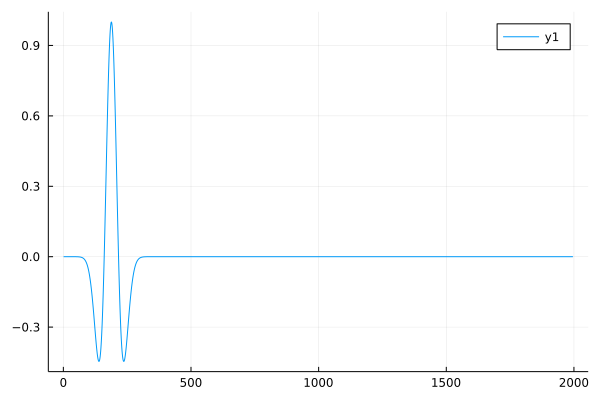

In [5]:
wav, tgrid=ricker(medium, 8, 1, 0.4)
dt=step(tgrid)

tmax=maximum(tgrid); nt=length(tgrid); 
print("nt:\t",length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)


srcwav = SrcWav(tgrid, ageom, [:vx])
GeoPhyInv.update!(srcwav, [:vx], wav)

plot(wav)

In [7]:
# CUDA.reclaim()
pa = SeisForwExpt(
    FdtdAcou(),
    npw = 1,
    medium = medium,
    ageom = [ageom],
    srcwav = [srcwav],
    rfields= [:vz],
    sflags = [2],
    rflags = [1],
    tgrid = tgrid,
    verbose = true,
);


┌ Info: spatial sampling (9.35e+00) can be as high as 2.72e+01
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:36
┌ Info: time sampling (1.07e-03) can be as high as 1.34e-03
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:51


In [10]:

ENV["GKSwstype"] = "nul";
if (isdir("viz3D_out") == false)
    mkdir("viz3D_out")
else
    foreach(rm, filter(endswith(".png"), readdir("./viz3D_out", join = true)))
end;
loadpath = "./viz3D_out/";
anim1 = Animation(loadpath, String["slice y"])
nout=div(nt,100)
println("Animation directory: $(anim1.dir)")
GeoPhyInv.initialize!(localpart(pa.p))
@showprogress for it = 1:nt
#     println(maximum(Array(localpart(pa.p)[1].w1[:t][:vx])))
    GeoPhyInv.advance!(pa.c, localpart(pa.p))
    # Visualisation

	GeoPhyInv.add_source!(it, 1, 1, pa.c, localpart(pa.p))

    if mod(it, nout) == 0
    
        if(length(mgrid)==2)
            heatmap(Array(localpart(pa.p)[1].w1[:t][:vx]),         
            aspect_ratio = 2,
            # xlims = (1, nx + 1),
            # ylims = (1, nz),
                yflip=true,
            c = :seismic,
            title = "vx",
#             clims = (-100, 100),
        )
        else 
            heatmap(Array(localpart(pa.p)[1].w1[:t][:vx])[1:end, div(ny,2), 1:end],
            aspect_ratio = 1,
            # xlims = (1, nx + 1),
            # ylims = (1, nz),
#                 yflip=true,
            c = :seismic,
            title = "vx",
#             clims = (-0.1, 0.1),
        )
        end
       
        frame(anim1)
    end

end


Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
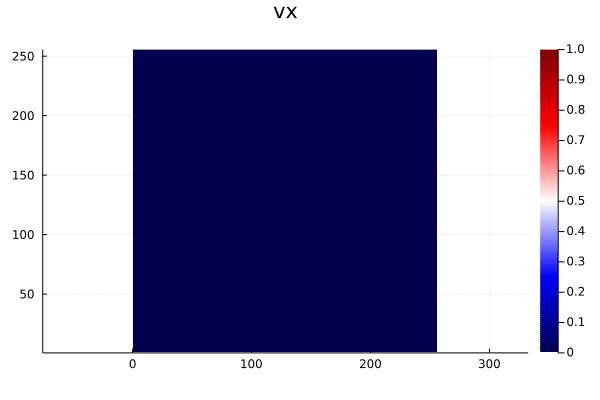

In [11]:
gif(anim1, "acoustic3D.gif", fps=10)


In [12]:
size(localpart(pa.p)[1].w1[:t][:dpdz])
# typeof(pa.c.mod[:M])
GeoPhyInv.update!(pa)

┌ Warning: Performing scalar indexing on task Task (runnable) @0x0000150fa8337c70.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/pawan/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56
	modeling supershot 1/1 100%|███████████████████████████| Time: 0:00:12


 ──────────────────────────────────────────────────────────────────────────
                                   Time                   Allocations      
                           ──────────────────────   ───────────────────────
     Tot / % measured:          14.2s / 96.1%            905MiB / 94.0%    

 Section           ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────
 mod_x_proc!            1    13.0s  95.1%   13.0s    772MiB  90.7%   772MiB
 stack_grads!           1    333ms  2.44%   333ms   61.9MiB  7.27%  61.9MiB
 initialize!            1    262ms  1.92%   262ms   14.4MiB  1.69%  14.4MiB
 record data            1   79.6ms  0.58%  79.6ms   2.78MiB  0.33%  2.78MiB
 update gradient        1    752ns  0.00%   752ns     0.00B  0.00%    0.00B
 ──────────────────────────────────────────────────────────────────────────  


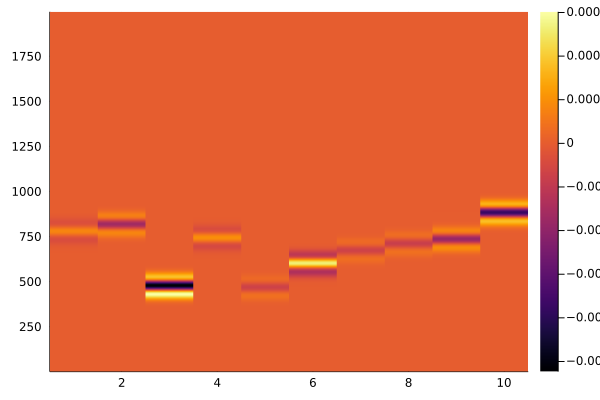

In [13]:
# gr()
# pa.c.pml[:x][:a][end-16:end]
heatmap(pa[:data][:vz])
